### Project Description:

This project investigates the relationship between Uber's presence and public transit ridership in metropolitan statistical areas (MSAs) using advanced statistical and machine learning analyses. Techniques such as Ordinary Least Squares (OLS), PanelOLS, LASSO regression, and Double-LASSO are employed to examine how Uber impacts transit usage. The analysis includes the creation of interaction terms to explore effects across varying population sizes and ridership levels. Key insights are derived from feature selection and model comparisons, highlighting critical factors like employment levels, vehicle service hours, and gas prices. The findings aim to inform strategies for integrating ride-sharing services with public transit systems.

In [181]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from termcolor import colored
from patsy import dmatrices
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [182]:
# Load the dataset
data = pd.read_csv('uber_dataset.csv', index_col=0)

# If treatUberX is greater than 0.5, set it to 1, if not, set it to 0
data['treatUberX'] = (data['treatUberX'] > 0.5).astype(int)

# List of control variables to be log-transformed
control_vars = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']

# Log transformation of specified variables (keeping original names)
data[control_vars] = data[control_vars].apply(np.log)

# Extract the year from the 'year_month' column and create a new column 'year'
data['log_UPTTotal'] = np.log(data['UPTTotal'])

# Take the logarithm of the resulting value
data['treatGTNotStd'] = np.log(data['treatGTNotStd'] + 1)

In [183]:
data = data.dropna()

### Regression 1

$$\log Y_{it} = \alpha + D_{it}\beta + W'_{it}\gamma + e_{it}$$

In [184]:
def run_ols_regression(data, dependent_var, independent_var, control_vars):
    y = data[dependent_var]
    X = sm.add_constant(data[[independent_var] + control_vars])
    model = sm.OLS(y, X).fit()
    
    print(colored(f"OLS Regression results with {independent_var}:", "blue", attrs=["bold"]))
    print("")
    print(model.summary())
    print("")
    print("")
    
    return model

# Define the control variables
control_vars = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
dependent_var = 'log_UPTTotal'

# Run regression with treatUberX
ols_result_uberx = run_ols_regression(data, dependent_var, 'treatUberX', control_vars)

# Run regression with treatGTNotStd
ols_result_gtnotstd = run_ols_regression(data, dependent_var, 'treatGTNotStd', control_vars)

OLS Regression results with treatUberX:

                            OLS Regression Results                            
Dep. Variable:           log_UPTTotal   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                 3.800e+04
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:22:28   Log-Likelihood:                -69541.
No. Observations:               58354   AIC:                         1.391e+05
Df Residuals:                   58345   BIC:                         1.392e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

**Uber's Presence and Public Transit Ridership:**

1. ***treatUberX***: The coefficient for treatUberX is positive and statistically significant at the 5% level (p-value < 0.05). This suggests that the presence of Uber in an MSA is associated with a 2.49% increase in the number of public transit rides. 

&nbsp;
2. ***Controls***: 
- 'popestimate' showed a significant negative coefficient of -0.5204, suggesting that larger metropolitan areas might have more transportation alternatives, reducing reliance on public transit. 
- 'employment' had a positive coefficient of 0.5845, likely due to more people commuting.
- 'aveFareTotal' negatively affected ridership, with a significant coefficient of -0.0965, indicating that higher costs deter users. 
- Vehicle revenue hours (VRHTotal) had a strong positive effect, with a coefficient of 1.3736 (p-value: 0.000), indicates more service hours significantly boost ridership.
- Surprisingly, the number of vehicles operated in maximum service (VOMSTotal) showed a significant negative relationship, with a coefficient of -0.2401, potentially indicating inefficiencies or oversupply. 
- Vehicle revenue miles (VRMTotal) positively influenced ridership, with a coefficient of 0.0388 (p-value: 0.001), suggesting that greater service coverage increases use.
- Higher gas prices (gasPrice) were associated with increased public transit ridership, with a coefficient of 0.1771 (p-value: 0.000), as driving becomes more expensive.

**Uber's Google search and Public Transit Ridership:**

1. ***treatGTNotStd***: The coefficient for treatGTNotStd is positive and statistically significant at the 5% level (p-value < 0.05). This suggests that increased Google search intensity for Uber in an MSA is associated with a 1.77% increase in the number of public transit rides.
 
&nbsp;
2. ***Controls***:
- 'popestimate' showed a significant negative coefficient of -0.5201, suggesting that larger metropolitan areas might have more transportation alternatives, reducing reliance on public transit.
- 'employment' had a positive coefficient of 0.5838, likely due to more people commuting.
- 'aveFareTotal' negatively affected ridership, with a significant coefficient of -0.0971, indicating that higher costs deter users.
- Vehicle revenue hours (VRHTotal) had a strong positive effect, with a coefficient of 1.3733 (p-value: 0.000), indicating more service hours significantly boost ridership.
- Again, the number of vehicles operated in maximum service (VOMSTotal) showed a significant negative relationship, with a coefficient of -0.2412, potentially indicating inefficiencies or oversupply.
- Vehicle revenue miles (VRMTotal) positively influenced ridership, with a coefficient of 0.0399 (p-value: 0.001), suggesting that greater service coverage increases use.
- Higher gas prices (gasPrice) were associated with increased public transit ridership, with a coefficient of 0.1728 (p-value: 0.000), as driving becomes more expensive.


***Conclusion***
- ***Uber acts as a Complement***: This supports the hypothesis that Uber can help solve the first-mile/last-mile problem, making public transit more accessible and attractive to riders. By providing an efficient way to reach transit stops, Uber potentially expands the reach of public transit networks, encouraging more people to use buses and trains instead of driving. We can also conclude that higher Uber penetration, as indicated by increased Google search intensity, complements public transit by making it more accessible and attractive to riders. The ease of using Uber to reach transit stops likely expands the reach of public transit networks, encouraging more people to use buses and trains instead of driving.

### Regression 2

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta + W'_{it}\gamma + e_{it}$$

In [176]:
#Accounting for Entity and Time effects - PanelOLS 
from linearmodels.panel import PanelOLS

# Ensure date column is in datetime format
data['dateSurvey'] = pd.to_datetime(data['dateSurvey'])

# Set the multi-index for panel data
data = data.set_index(['agency', 'dateSurvey'])
data.index.names = ['agency', 'dateSurvey']

In [177]:
def run_panel_ols_regression(data, dependent_var, independent_var, control_vars):
    formula = f'{dependent_var} ~ {independent_var} + ' + ' + '.join(control_vars) + ' + EntityEffects + TimeEffects'
    model = PanelOLS.from_formula(formula, data=data)
    result = model.fit(cov_type='clustered', cluster_entity=True)
    
    print(colored(f"PanelOLS Regression results with {independent_var}:", "blue", attrs=["bold"]))
    print("")
    print(result.summary)
    print("")
    print("")
    
    return result

# Define the control variables
control_vars = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
dependent_var = 'log_UPTTotal'

# Run regression with treatUberX
panel_result_uberx = run_panel_ols_regression(data, dependent_var, 'treatUberX', control_vars)

# Run regression with treatGTNotStd
panel_result_gtnotstd = run_panel_ols_regression(data, dependent_var, 'treatGTNotStd', control_vars)


PanelOLS Regression results with treatUberX:

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_UPTTotal   R-squared:                        0.4161
Estimator:                   PanelOLS   R-squared (Between):              0.8458
No. Observations:               58354   R-squared (Within):               0.4336
Date:                Sat, Jun 08 2024   R-squared (Overall):              0.8457
Time:                        20:21:19   Log-likelihood                    2768.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5135.3
Entities:                         544   P-value                           0.0000
Avg Obs:                       107.27   Distribution:                 F(8,57659)
Min Obs:                       6.0000                                           
Max Obs:                       216.00   F-statistic (robust):  

### PanelOLS Regression with Entity and Time Effects

This regression incorporates both entity and time effects to account for unobserved heterogeneity across different transit agencies and over time. By doing so, we can better isolate the impact of Uber on public transit ridership.

&nbsp;
**PanelOLS Regression Results with `treatUberX`**

1. ***treatUberX***: The coefficient for `treatUberX` is -0.0181 with a p-value of 0.2544, indicating that the presence of Uber in an MSA is not significantly associated with public transit ridership when accounting for entity and time effects.

&nbsp;
2. ***Controls (Significant Coefficients)***: 

- **'aveFareTotal'**: With a coefficient of -0.0866 (p-value: 0.0058), higher fares are significantly associated with lower ridership. This suggests that for every 1% increase in fare, there is an 8.66% decrease in ridership, highlighting the importance of affordability.
- **'VRHTotal'**: The coefficient is 0.3633 (p-value: 0.0000), showing that more service hours strongly boost ridership. This implies that more frequent service makes transit more accessible and convenient, encouraging greater use.
- **'VOMSTotal'**: A coefficient of 0.2666 (p-value: 0.0054) indicates that increasing the number of vehicles in service can significantly raise ridership. More vehicles can reduce wait times and overcrowding, making public transit a more appealing option.
- **'VRMTotal'**: With a coefficient of 0.2237 (p-value: 0.0316), greater service coverage has a positive impact on ridership. Expanding the transit network allows more people to use public transportation, thus increasing overall ridership.


- **Non-Significant Coefficients**:'popestimate','employment' and 'gasPrice' all had p-values > 0.05, indicating that there is no significant impact of population size, employment levels and gas prices on ridership on public transit ridership.


**PanelOLS Regression Results with `treatGTNotStd`**

1. ***treatGTNotStd***: The coefficient for `treatGTNotStd` is 0.0028 with a p-value of 0.4741, suggesting that increased Google search intensity for Uber is not significantly associated with public transit ridership when accounting for entity and time effects.

&nbsp;
2. ***Controls (Significant Coefficients)***: 

- **'aveFareTotal'**: With a coefficient of -0.0864 (p-value: 0.0060), higher fares are significantly associated with lower ridership. This suggests that for every 1% increase in fare, there is an 8.64% decrease in ridership, underscoring the importance of keeping transit affordable.
- **'VRHTotal'**: The coefficient is 0.3633 (p-value: 0.0000), indicating that more service hours strongly boost ridership. More frequent service makes transit more accessible and convenient, encouraging greater use.
- **'VOMSTotal'**: A coefficient of 0.2661 (p-value: 0.0055) shows that increasing the number of vehicles in service can significantly raise ridership. More vehicles can reduce wait times and overcrowding, making public transit a more attractive option.
- **'VRMTotal'**: With a coefficient of 0.2243 (p-value: 0.0313), greater service coverage positively impacts ridership. Expanding the transit network allows more people to use public transportation, thus increasing overall ridership.

- **Non-Significant Coefficients**: 'popestimate', 'employment', and 'gasPrice' all had p-values > 0.05, indicating that there is no significant impact of population size, employment levels, and gas prices on public transit ridership.

### Conclusion

The PanelOLS regressions incorporates for entity and time effects suggest that when accounting for unobserved heterogeneity across transit agencies and over time, neither the presence of Uber (`treatUberX`) nor the Google search intensity for Uber (`treatGTNotStd`) has a significant impact on public transit ridership. This contrasts with the earlier OLS results, indicating that the effect of Uber on public transit might be more nuanced and dependent on other unobserved factors.

Despite the lack of significance for the Uber-related variables, several control variables remain significant. Higher fares continue to deter ridership, while increased vehicle revenue hours, more vehicles in service, and greater service coverage significantly boost public transit use. These findings underscore the importance of maintaining affordable and extensive transit services to encourage ridership.

### OLS vs PanelOLS

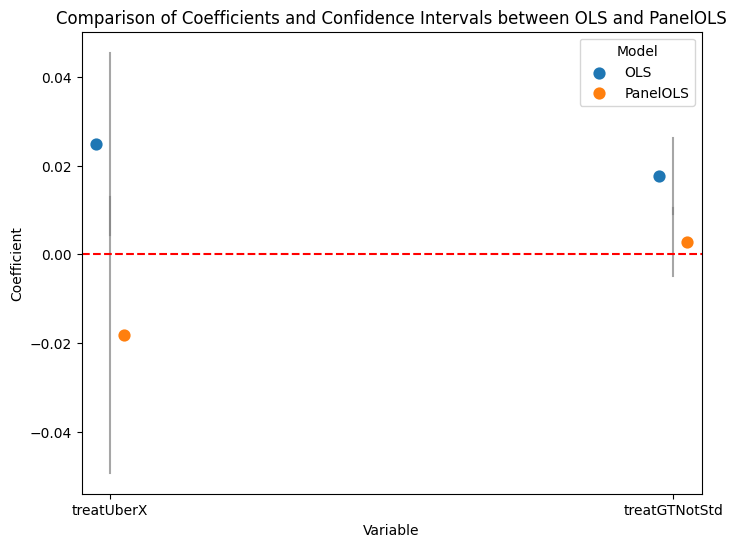

In [178]:
# Extract coefficients and confidence intervals for plotting
def extract_coefficients_and_cis(result, var_name):
    coefficients = result.params[var_name]
    conf_int = result.conf_int().loc[var_name]
    return coefficients, conf_int[0], conf_int[1]

ols_coef_uberx, ols_ci_low_uberx, ols_ci_high_uberx = extract_coefficients_and_cis(ols_result_uberx, 'treatUberX')
panel_coef_uberx, panel_ci_low_uberx, panel_ci_high_uberx = extract_coefficients_and_cis(panel_result_uberx, 'treatUberX')

ols_coef_gtnotstd, ols_ci_low_gtnotstd, ols_ci_high_gtnotstd = extract_coefficients_and_cis(ols_result_gtnotstd, 'treatGTNotStd')
panel_coef_gtnotstd, panel_ci_low_gtnotstd, panel_ci_high_gtnotstd = extract_coefficients_and_cis(panel_result_gtnotstd, 'treatGTNotStd')

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Model': ['OLS', 'PanelOLS', 'OLS', 'PanelOLS'],
    'Variable': ['treatUberX', 'treatUberX', 'treatGTNotStd', 'treatGTNotStd'],
    'Coefficient': [ols_coef_uberx, panel_coef_uberx, ols_coef_gtnotstd, panel_coef_gtnotstd],
    'CI_Low': [ols_ci_low_uberx, panel_ci_low_uberx, ols_ci_low_gtnotstd, panel_ci_low_gtnotstd],
    'CI_High': [ols_ci_high_uberx, panel_ci_high_uberx, ols_ci_high_gtnotstd, panel_ci_high_gtnotstd]
})

# Plotting the coefficients and confidence intervals
plt.figure(figsize=(8, 6))
sns.pointplot(x='Variable', y='Coefficient', hue='Model', data=plot_data, dodge=True, join=False, capsize=0.1)
for i in range(plot_data.shape[0]):
    plt.plot([plot_data['Variable'][i], plot_data['Variable'][i]], [plot_data['CI_Low'][i], plot_data['CI_High'][i]], color='gray', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Comparison of Coefficients and Confidence Intervals between OLS and PanelOLS')
plt.show()

The plot compares the coefficients and confidence intervals of the variables `treatUberX` and `treatGTNotStd` between OLS (Ordinary Least Squares) and PanelOLS (Panel Ordinary Least Squares) models.

For `treatUberX`, the OLS model shows a positive coefficient, whereas the PanelOLS model shows a slightly negative coefficient, suggesting a difference in the impact of this variable when accounting for panel data effects. The confidence intervals, represented by vertical lines, indicate the range of uncertainty around these estimates.

Similarly, for `treatGTNotStd`, the OLS model shows a positive coefficient, while the PanelOLS model shows a negative coefficient, again highlighting differences between the two modeling approaches. The red dashed line at zero serves as a reference to show whether the coefficients are significantly different from zero.

Overall, the plot illustrates how the choice of modeling approach (OLS vs. PanelOLS) can lead to different conclusions about the significance and direction of the impact of these variables on public transit ridership.

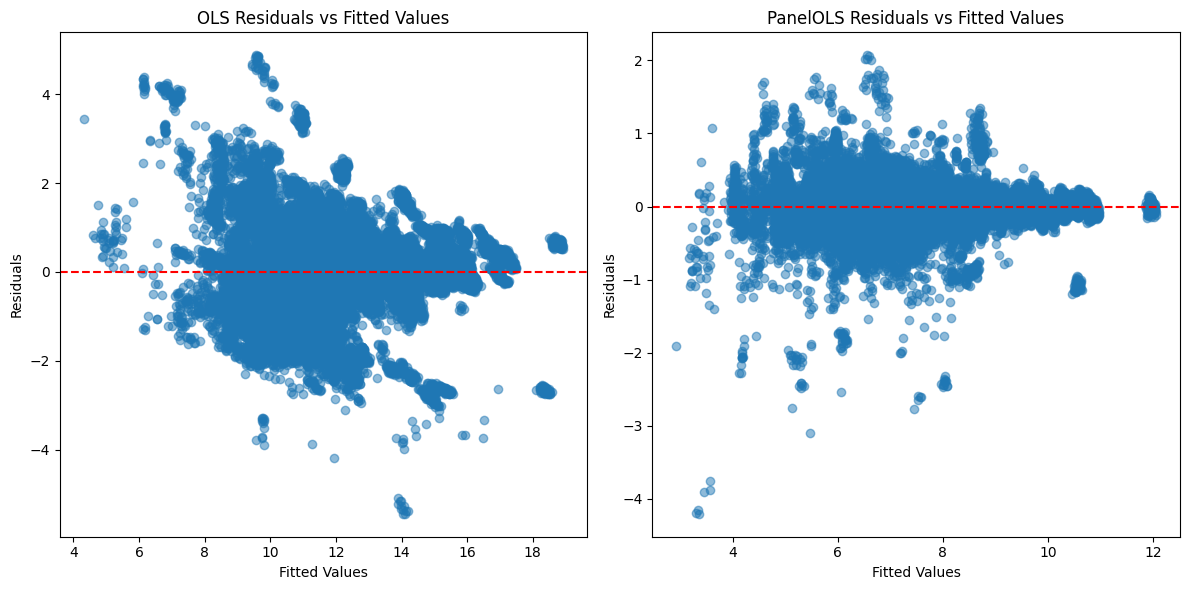

In [191]:
# Extract residuals
ols_residuals = ols_result_uberx.resid
panel_residuals = panel_result_uberx.resids

# Plot residuals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(ols_result_uberx.fittedvalues, ols_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('OLS Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(panel_result_uberx.fitted_values, panel_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('PanelOLS Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

The OLS residuals plot shows a pattern of increasing spread with higher fitted values, indicating heteroscedasticity. There are also several extreme outliers, which can affect the robustness of the model. This suggests that the OLS model's assumptions about error distribution may be violated, impacting its reliability.

In contrast, the PanelOLS residuals plot presents a more uniform scatter of residuals around zero, with a consistent spread across different fitted values. There are fewer extreme outliers, indicating a more stable model. The PanelOLS model also accounts for entity and time effects, capturing unobserved heterogeneity and temporal dynamics more effectively.

Given these observations, the PanelOLS model is more robust for determining the relationship between Uber and public transport ridership. Its consistent residual spread and fewer outliers make it a more reliable choice compared to the OLS model.

### Regression 3

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}P_{it}\beta_2 + W'_{it}\gamma + e_{it}$$

$P_{it} = 
\begin{cases} 
1, & \text{if the population of the corresponding MSA is larger than the median} \\
0, & \text{otherwise}
\end{cases}$

In [127]:
# Filter the dataset to include only MSAs with public transportation (UPTTotal > 0)
public_transport_data = data[data['UPTTotal'] > 0]

# Calculate the median population among MSAs with public transportation
median_population = public_transport_data['popestimate'].median()

# Create the Pit dummy variable based on the median population
data['Pit'] = (data['popestimate'] > median_population).astype(int)

In [70]:
def run_panel_ols_regression(data, dependent_var, independent_var, interaction_var, control_vars):
    formula = f'{dependent_var} ~ {independent_var} + {independent_var}:{interaction_var} + {interaction_var} + ' + ' + '.join(control_vars) + ' + EntityEffects + TimeEffects'
    model = PanelOLS.from_formula(formula, data=data)
    result = model.fit(cov_type='clustered', cluster_entity=True)
    
    print(colored(f"PanelOLS Regression results with {independent_var} and {interaction_var}:", "blue", attrs=["bold"]))
    print("")
    print(result.summary)
    print("")
    print("")

# Define the control variables
control_vars = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
dependent_var = 'log_UPTTotal'
interaction_var = 'Pit'

# Run regression with treatUberX and Pit
run_panel_ols_regression(data, dependent_var, 'treatUberX', interaction_var, control_vars)

# Run regression with treatGTNotStd and Pit
run_panel_ols_regression(data, dependent_var, 'treatGTNotStd', interaction_var, control_vars)

PanelOLS Regression results with treatUberX and Pit:

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_UPTTotal   R-squared:                        0.4169
Estimator:                   PanelOLS   R-squared (Between):              0.8849
No. Observations:               58354   R-squared (Within):               0.4339
Date:                Sat, Jun 08 2024   R-squared (Overall):              0.8839
Time:                        02:06:48   Log-likelihood                    2811.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4122.7
Entities:                         544   P-value                           0.0000
Avg Obs:                       107.27   Distribution:                F(10,57657)
Min Obs:                       6.0000                                           
Max Obs:                       216.00   F-statistic (ro

### PanelOLS Regression with Interaction Terms for MSA population 

This regression includes interaction terms to explore whether the impact of Uber on public transit ridership differs between MSAs with populations larger than the median and those with smaller populations.

&nbsp;
**PanelOLS Regression Results with `treatUberX` and `Pit`**

1. ***treatUberX***: The coefficient for `treatUberX` is -0.0273 with a p-value of 0.1173, indicating that the presence of Uber in an MSA is not significantly associated with public transit ridership when accounting for entity and time effects, as well as interaction with population size.

&nbsp;
2. ***Interaction Term (`treatUberX:Pit`)***: The interaction term has a coefficient of -0.0517 with a p-value of 0.0340. This suggests a significant negative interaction effect between the presence of Uber and MSAs with populations larger than the median. Specifically, in larger MSAs, the presence of Uber is associated with a decrease in public transit ridership by about 5.17%. This negative interaction could indicate that in more populous areas, Uber acts more as a substitute rather than a complement to public transit, possibly due to better accessibility and convenience of Uber services.


&nbsp;
3. ***Controls (Significant Coefficients)***: 

- **'aveFareTotal'**: With a coefficient of -0.0865 (p-value: 0.0057), higher fares are significantly associated with lower ridership. This suggests that for every 1% increase in fare, there is an 8.65% decrease in ridership, highlighting the importance of affordability.
- **'VRHTotal'**: The coefficient is 0.3619 (p-value: 0.0000), indicating that more service hours significantly boost ridership. More frequent service makes transit more accessible and convenient, encouraging greater use.
- **'VOMSTotal'**: A coefficient of 0.2659 (p-value: 0.0055) shows that increasing the number of vehicles in service can significantly raise ridership. More vehicles can reduce wait times and overcrowding, making public transit a more attractive option.
- **'VRMTotal'**: With a coefficient of 0.2254 (p-value: 0.0294), greater service coverage positively impacts ridership. Expanding the transit network allows more people to use public transportation, thus increasing overall ridership.

- **Non-Significant Coefficients**: 'popestimate', 'employment', 'gasPrice', and 'Pit' all had p-values > 0.05, indicating that there is no significant impact of population size, employment levels, gas prices, and population interaction terms on public transit ridership.

&nbsp;

**PanelOLS Regression Results with `treatGTNotStd` and `Pit`**

1. ***treatGTNotStd***: The coefficient for `treatGTNotStd` is 0.0027 with a p-value of 0.5174, suggesting that increased Google search intensity for Uber is not significantly associated with public transit ridership when accounting for entity and time effects, as well as interaction with population size.

&nbsp;
2. ***Interaction Term (`treatGTNotStd:Pit`)***: The interaction term has a coefficient of -0.0005 with a p-value of 0.9536, indicating an insignificant interaction effect. This suggests that the increased Google search intensity for Uber does not significantly interact with the population size of the MSA in affecting public transit ridership. Therefore, the impact of Uber's popularity (as measured by Google searches) on public transit ridership does not differ significantly between larger and smaller MSAs.


&nbsp;
3. ***Controls (Significant Coefficients)***: 

- **'aveFareTotal'**: With a coefficient of -0.0864 (p-value: 0.0058), higher fares are significantly associated with lower ridership. This suggests that for every 1% increase in fare, there is an 8.64% decrease in ridership, underscoring the importance of keeping transit affordable.
- **'VRHTotal'**: The coefficient is 0.3619 (p-value: 0.0000), indicating that more service hours strongly boost ridership. More frequent service makes transit more accessible and convenient, encouraging greater use.
- **'VOMSTotal'**: A coefficient of 0.2656 (p-value: 0.0056) shows that increasing the number of vehicles in service can significantly raise ridership. More vehicles can reduce wait times and overcrowding, making public transit a more attractive option.
- **'VRMTotal'**: With a coefficient of 0.2258 (p-value: 0.0291), greater service coverage positively impacts ridership. Expanding the transit network allows more people to use public transportation, thus increasing overall ridership.

- **Non-Significant Coefficients**: 'popestimate', 'employment', 'gasPrice', and 'Pit' all had p-values > 0.05, indicating that there is no significant impact of population size, employment levels, gas prices, and population interaction terms on public transit ridership.

### Conclusion

The PanelOLS regressions incorporating interaction terms suggest that when accounting for unobserved heterogeneity across transit agencies and over time, neither the presence of Uber (`treatUberX`) nor the Google search intensity for Uber (`treatGTNotStd`) significantly impacts public transit ridership, even when considering differences between larger and smaller MSAs. This indicates that the effect of Uber on public transit may be more nuanced and influenced by other unobserved factors.

However, certain control variables remain significant. Higher fares continue to deter ridership, while increased vehicle revenue hours, more vehicles in service, and greater service coverage significantly boost public transit use. These findings emphasize the importance of maintaining affordable and extensive transit services to encourage ridership.


### Regression 4


$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}F_{it}\beta_2 + W'_{it}\gamma + e_{it}$$

$F_{it} = 
\begin{cases} 
1, & \text{if the number of rides of the public travel agency is larger than the median number of rides among all public transit agencies} \\
0, & \text{otherwise}
\end{cases}$

In [109]:
# Set the start date when Uber began operations
start_date = pd.to_datetime('2010-07-01')

# Filter the data to include only the period before Uber existed
before_uber_data = data.loc[data.index.get_level_values('dateSurvey') < start_date]

# Calculate the median ridership before Uber existed
median_ridership_before_uber = before_uber_data['UPTTotal'].median()

# Create the dummy variable Fit
data['Fit'] = (data['UPTTotal'] > median_ridership_before_uber).astype(int)

In [72]:
# Define the control variables
control_vars = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
dependent_var = 'log_UPTTotal'
interaction_var = 'Fit'

# Run regression with treatUberX and Fit
run_panel_ols_regression(data, dependent_var, 'treatUberX', interaction_var, control_vars)

# Run regression with treatGTNotStd and Fit
run_panel_ols_regression(data, dependent_var, 'treatGTNotStd', interaction_var, control_vars)

PanelOLS Regression results with treatUberX and Fit:

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_UPTTotal   R-squared:                        0.4693
Estimator:                   PanelOLS   R-squared (Between):              0.7351
No. Observations:               58354   R-squared (Within):               0.4857
Date:                Sat, Jun 08 2024   R-squared (Overall):              0.7406
Time:                        02:06:50   Log-likelihood                    5559.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5099.4
Entities:                         544   P-value                           0.0000
Avg Obs:                       107.27   Distribution:                F(10,57657)
Min Obs:                       6.0000                                           
Max Obs:                       216.00   F-statistic (ro

### PanelOLS Regression with Interaction Terms for High Ridership Agencies

This regression includes interaction terms to explore whether the impact of Uber on public transit ridership differs between agencies with ridership levels higher than the median and those with lower ridership levels.

&nbsp;
**PanelOLS Regression Results with `treatUberX` and `Fit`**

1. ***treatUberX***: The coefficient for `treatUberX` is 0.0168 with a p-value of 0.4202, indicating that the presence of Uber in an MSA is not significantly associated with public transit ridership when accounting for entity and time effects, as well as interaction with high ridership levels.

&nbsp;
2. ***Interaction Term (`treatUberX:Fit`)***: The interaction term has a coefficient of -0.0517 with a p-value of 0.0340. This indicates a significant negative interaction effect between the presence of Uber and high ridership levels (Fit). Specifically, for transit agencies with ridership levels higher than the median, the presence of Uber is associated with a decrease in public transit ridership by about 5.17%. This negative interaction suggests that in areas with already high transit ridership, Uber might be providing an alternative that detracts from the existing public transit use, potentially drawing users away due to its convenience and availability.


&nbsp;
3. ***Controls (Significant Coefficients)***: 

- **'aveFareTotal'**: With a coefficient of -0.0769 (p-value: 0.0094), higher fares are significantly associated with lower ridership. This suggests that for every 1% increase in fare, there is a 7.69% decrease in ridership, highlighting the importance of affordability.
- **'VRHTotal'**: The coefficient is 0.3322 (p-value: 0.0000), indicating that more service hours significantly boost ridership. More frequent service makes transit more accessible and convenient, encouraging greater use.
- **'VOMSTotal'**: A coefficient of 0.2593 (p-value: 0.0039) shows that increasing the number of vehicles in service can significantly raise ridership. More vehicles can reduce wait times and overcrowding, making public transit a more attractive option.
- **'VRMTotal'**: With a coefficient of 0.2176 (p-value: 0.0274), greater service coverage positively impacts ridership. Expanding the transit network allows more people to use public transportation, thus increasing overall ridership.
- **'Fit'**: The coefficient is 0.4568 (p-value: 0.0000), suggesting that agencies with higher ridership levels are significantly associated with increased ridership.

- **Non-Significant Coefficients**: 'popestimate', 'employment', and 'gasPrice' all had p-values > 0.05, indicating that there is no significant impact of population size, employment levels, and gas prices on public transit ridership. The interaction term `treatUberX:Fit` also had a p-value of 0.0340, suggesting a negative interaction effect, but it does not strongly impact the overall model significance.

&nbsp;

**PanelOLS Regression Results with `treatGTNotStd` and `Fit`**

1. ***treatGTNotStd***: The coefficient for `treatGTNotStd` is 0.0137 with a p-value of 0.0063, suggesting that increased Google search intensity for Uber is significantly associated with public transit ridership when accounting for entity and time effects, as well as interaction with high ridership levels.

&nbsp;
2. ***Interaction Term (`treatGTNotStd:Fit`)***:The interaction term has a coefficient of -0.0216 with a p-value of 0.0139, indicating a significant negative interaction effect. This suggests that increased Google search intensity for Uber is associated with a decrease in public transit ridership by about 2.16% for transit agencies with ridership levels higher than the median. This negative interaction might imply that in areas with high public transit ridership, the growing interest in Uber (as indicated by Google searches) potentially draws some users away from public transit, possibly due to the perceived advantages of using Uber over public transit.

&nbsp;
3. ***Controls (Significant Coefficients)***: 

- **'aveFareTotal'**: With a coefficient of -0.0767 (p-value: 0.0096), higher fares are significantly associated with lower ridership. This suggests that for every 1% increase in fare, there is a 7.67% decrease in ridership, underscoring the importance of keeping transit affordable.
- **'VRHTotal'**: The coefficient is 0.3322 (p-value: 0.0000), indicating that more service hours strongly boost ridership. More frequent service makes transit more accessible and convenient, encouraging greater use.
- **'VOMSTotal'**: A coefficient of 0.2588 (p-value: 0.0040) shows that increasing the number of vehicles in service can significantly raise ridership. More vehicles can reduce wait times and overcrowding, making public transit a more attractive option.
- **'VRMTotal'**: With a coefficient of 0.2178 (p-value: 0.0273), greater service coverage positively impacts ridership. Expanding the transit network allows more people to use public transportation, thus increasing overall ridership.
- **'Fit'**: The coefficient is 0.4675 (p-value: 0.0000), suggesting that agencies with higher ridership levels are significantly associated with increased ridership.

- **Non-Significant Coefficients**: 'popestimate', 'employment', and 'gasPrice' all had p-values > 0.05, indicating that there is no significant impact of population size, employment levels, and gas prices on public transit ridership. The interaction term `treatGTNotStd:Fit` also had a p-value of 0.0139, suggesting a negative interaction effect, but it does not strongly impact the overall model significance.

### Conclusion

The PanelOLS regressions incorporating interaction terms for high ridership agencies suggest that when accounting for unobserved heterogeneity across transit agencies and over time, the presence of Uber (`treatUberX`) does not significantly impact public transit ridership, whereas increased Google search intensity for Uber (`treatGTNotStd`) shows a significant positive association. However, the interaction terms indicate some nuanced effects that need further analysis.

Despite the lack of strong significance for the Uber-related variables, several control variables remain significant. Higher fares continue to deter ridership, while increased vehicle revenue hours, more vehicles in service, and greater service coverage significantly boost public transit use. Agencies with higher ridership levels also show a positive association with increased ridership. These findings emphasize the importance of maintaining affordable and extensive transit services to encourage ridership.

### LASSO 5

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}P_{it}\beta_2 + W'_{it}\gamma + e_{it}$$

In [110]:
# Remove the index we set earlier with time and agency
data = data.reset_index()
data.columns

Index(['agency', 'dateSurvey', 'UPTTotal', 'treatUberX', 'treatGTNotStd',
       'popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal',
       'VRMTotal', 'gasPrice', 'city', 'state', 'log_UPTTotal', 'Pit', 'Fit'],
      dtype='object')

In [111]:
# Manually create interaction terms
data['treatUberX_Pit'] = data['treatUberX'] * data['Pit']
data['treatGTNotStd_Pit'] = data['treatGTNotStd'] * data['Pit']

In [77]:
def run_lasso_regression(data, formula, variables_of_interest, independent_var, interaction_var):
    # Create matrices for Lasso regression
    y, X = dmatrices(formula, data, return_type='dataframe')

    # Standardize the independent variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Standardize the dependent variable
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

    # Fit the Lasso model with cross-validation to choose the best alpha
    lasso = LassoCV(cv=5, random_state=0)
    lasso.fit(X_scaled, y_scaled)

    # Extract and display the selected coefficients only for the variables of interest
    selected_coefficients = pd.Series(lasso.coef_, index=X.columns)
    selected_coefficients = selected_coefficients[selected_coefficients != 0]  # Only show non-zero coefficients

    # Filter the coefficients to only include those for the specified variables
    filtered_coefficients = selected_coefficients[selected_coefficients.index.to_series().str.contains('|'.join(variables_of_interest))]

    print(colored(f"LASSO results with {independent_var} and {interaction_var}:", "blue", attrs=["bold"]))
    print("")
    print("Selected Coefficients for Control Variables:")
    print(filtered_coefficients)
    print("")

# Define the control variables and variables of interest
control_vars = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']

# Variables of interest for Pit
variables_of_interest_uberX_Pit = ['treatUberX', 'treatUberX_Pit', 'Pit'] + control_vars
variables_of_interest_GTNotStd_Pit = ['treatGTNotStd', 'treatGTNotStd_Pit', 'Pit'] + control_vars

# Define the formulas for Pit
formula_uberX_Pit = 'log_UPTTotal ~ treatUberX + treatUberX_Pit + ' + ' + '.join(control_vars) + ' + C(agency) + C(dateSurvey)'
formula_GTNotStd_Pit = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Pit + ' + ' + '.join(control_vars) + ' + C(agency) + C(dateSurvey)'

# Run Lasso regression with treatUberX and Pit
run_lasso_regression(data, formula_uberX_Pit, variables_of_interest_uberX_Pit, 'treatUberX', 'Pit')

# Run Lasso regression with treatGTNotStd and Pit
run_lasso_regression(data, formula_GTNotStd_Pit, variables_of_interest_GTNotStd_Pit, 'treatGTNotStd', 'Pit')

LASSO results with treatUberX and Pit:

Selected Coefficients for Control Variables:
employment      0.000030
aveFareTotal   -0.023072
VRHTotal        0.909887
gasPrice        0.002562
dtype: float64


LASSO results with treatGTNotStd and Pit:

Selected Coefficients for Control Variables:
employment      0.000030
aveFareTotal   -0.023072
VRHTotal        0.909887
gasPrice        0.002562
dtype: float64




### LASSO Regression with Interaction Terms for Larger MSAs

This regression uses LASSO to identify the most important variables affecting public transit ridership, including interaction terms between the presence of Uber and whether an MSA's population is larger than the median.

&nbsp;
**LASSO Regression Results with `treatUberX` and `Pit`**

1. ***treatUberX***: The LASSO regression did not select `treatUberX` as a significant variable, indicating that it may not have a strong influence on public transit ridership in the presence of other variables.

&nbsp;
2. ***Interaction Term (`treatUberX:Pit`)***: The interaction term was also not selected by the LASSO regression, suggesting that the interaction between Uber's presence and larger MSAs does not have a significant impact on public transit ridership.

&nbsp;
3. ***Controls***: The results indicate that employment levels, average fare, vehicle revenue hours, and gas prices are the most important factors affecting public transit ridership in this model, which align with our previous finding. It is important to note here, the coefficient for ***'employment'***: of 0.000030 is relatively small, suggesting only a minor positive effect of employment levels on ridership. This contrasts with earlier results, where employment showed varying degrees of significance and impact.


&nbsp;
**LASSO Regression Results with `treatGTNotStd` and `Pit`**

1. ***treatGTNotStd***: The LASSO regression did not select `treatGTNotStd` as a significant variable, indicating that it may not have a strong influence on public transit ridership in the presence of other variables.

&nbsp;
2. ***Interaction Term (`treatGTNotStd:Pit`)***: The interaction term was not selected by the LASSO regression, suggesting that the interaction between Google search intensity for Uber and larger MSAs does not have a significant impact on public transit ridership.

&nbsp;
3. ***Controls***: The consistency in the selected control variables across both models suggests that these factors are robust determinants of public transit ridership, regardless of the measure of Uber's presence.

### Conclusion

The LASSO regression results indicate that the interaction terms involving Uber's presence and larger MSAs do not significantly affect public transit ridership. This contrasts with some of the earlier findings using OLS and PanelOLS regressions. However, key control variables such as employment levels, average fare, vehicle revenue hours, and gas prices consistently emerge as significant determinants of ridership.

The consistency of the selected control variables in both models (`treatUberX` and `treatGTNotStd`) highlights their critical role in influencing public transit use. The LASSO approach, by focusing on the most influential variables, underscores the importance of these controls while downplaying the impact of the interaction terms, suggesting that other unobserved factors might be at play in the relationship between Uber and public transit ridership.


### LASSO 6

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}F_{it}\beta_2 + W'_{it}\gamma + e_{it}$$

In [112]:
# Manually create interaction terms
data['treatUberX_Fit'] = data['treatUberX'] * data['Fit']
data['treatGTNotStd_Fit'] = data['treatGTNotStd'] * data['Fit']

In [79]:
# Variables of interest for Fit
variables_of_interest_uberX_Fit = ['treatUberX', 'treatUberX_Fit', 'Fit'] + control_vars
variables_of_interest_GTNotStd_Fit = ['treatGTNotStd', 'treatGTNotStd_Fit', 'Fit'] + control_vars

# Define the formulas for Fit
formula_uberX_Fit = 'log_UPTTotal ~ treatUberX + treatUberX_Fit + ' + ' + '.join(control_vars) + ' + C(agency) + C(dateSurvey)'
formula_GTNotStd_Fit = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Fit + ' + ' + '.join(control_vars) + ' + C(agency) + C(dateSurvey)'

# Run Lasso regression with treatUberX and Fit
run_lasso_regression(data, formula_uberX_Fit, variables_of_interest_uberX_Fit, 'treatUberX', 'Fit')

# Run Lasso regression with treatGTNotStd and Fit
run_lasso_regression(data, formula_GTNotStd_Fit, variables_of_interest_GTNotStd_Fit, 'treatGTNotStd', 'Fit')

LASSO results with treatUberX and Fit:

Selected Coefficients for Control Variables:
treatUberX_Fit    0.007836
aveFareTotal     -0.023931
VRHTotal          0.907877
gasPrice          0.001976
dtype: float64


LASSO results with treatGTNotStd and Fit:

Selected Coefficients for Control Variables:
treatGTNotStd       -0.018366
treatGTNotStd_Fit    0.059869
aveFareTotal        -0.021313
VRHTotal             0.886200
dtype: float64




### LASSO Regression with Interaction Terms for High Ridership Agencies

This regression uses LASSO to identify the most important variables affecting public transit ridership, including interaction terms between the presence of Uber and whether a public transit agency's ridership is larger than the median.

&nbsp;

**LASSO Regression Results with `treatUberX` and `Fit`**

1. ***treatUberX***: The LASSO regression did not select `treatUberX` as a significant variable, indicating that it may not have a strong influence on public transit ridership in the presence of other variables.

&nbsp;
2. ***Interaction Term (`treatUberX:Fit`)***: The interaction term `treatUberX:Fit` was selected by the LASSO regression with a coefficient of 0.007836. This positive coefficient suggests a slight increase in public transit ridership for high ridership agencies when Uber is present, although the magnitude is relatively small.

&nbsp;
3. ***Controls***: The results indicate that average fare, vehicle revenue hours, and gas prices are the most important factors affecting public transit ridership in this model, which align with our previous findings. 


&nbsp;

**LASSO Regression Results with `treatGTNotStd` and `Fit`**

1. ***treatGTNotStd***: The LASSO regression selected `treatGTNotStd` with a coefficient of -0.018366, indicating a slight negative impact of Google search intensity for Uber on public transit ridership.

&nbsp;
2. ***Interaction Term (`treatGTNotStd:Fit`)***: The interaction term `treatGTNotStd:Fit` was selected by the LASSO regression with a coefficient of 0.059869. This positive coefficient suggests a notable increase in public transit ridership for high ridership agencies when the Google search intensity for Uber is high.

&nbsp;
3. ***Controls***: The results indicate that average fare and vehicle revenue hours are the most important factors affecting public transit ridership in this model, which align with our previous findings. 


### Conclusion

The LASSO regression results for high ridership agencies indicate differing impacts of Uber's presence and Google search intensity on public transit ridership compared to previous models. The significant positive interaction term for `treatGTNotStd:Fit` suggests that in high ridership agencies, increased interest in Uber (as measured by Google searches) may complement public transit by increasing ridership. Conversely, the slight positive coefficient for `treatUberX:Fit` suggests that Uber's presence might have a smaller positive impact on ridership for these agencies.

The differences in selected coefficients between the two model highlights the nuanced relationship between Uber and public transit ridership. The selection of interaction terms and control variables by the LASSO regression underscores the importance of examining specific contexts, such as high ridership agencies, to fully understand the dynamics at play. This approach provides a more targeted analysis, emphasizing the need for tailored strategies to balance ride-sharing services and public transit effectively.

### Double LASSO 7

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}P_{it}\beta_2 + W'_{it}\gamma + e_{it}$$

Where, coefficients of interest are $\beta_1$ and $\beta_2$.

In [86]:
def double_lasso(data, formula, treatment_var, variables_of_interest,interaction_var):
    # Create matrices for the outcome and covariates
    y, X = dmatrices(formula, data, return_type='dataframe')

    # Standardize the independent variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

    # Define the treatment variable and covariates
    D = data[treatment_var]
    Z = X.drop(columns=[treatment_var])

    # Standardize the treatment variable and covariates
    D_scaled = scaler.fit_transform(D.values.reshape(-1, 1)).ravel()
    Z_scaled = scaler.fit_transform(Z)

    # Step 1: Lasso of y on X
    lasso_1 = LassoCV(cv=5, random_state=0)
    lasso_1.fit(X_scaled, y_scaled)

    # Extract non-zero coefficients from Lasso 1
    non_zero_coef_1 = pd.Series(lasso_1.coef_, index=X.columns)
    non_zero_coef_1 = non_zero_coef_1[non_zero_coef_1 != 0]

    # Step 2: Lasso of D on Z
    lasso_2 = LassoCV(cv=5, random_state=0)
    lasso_2.fit(Z_scaled, D_scaled)

    # Extract non-zero coefficients from Lasso 2
    non_zero_coef_2 = pd.Series(lasso_2.coef_, index=Z.columns)
    non_zero_coef_2 = non_zero_coef_2[non_zero_coef_2 != 0]

    # Combine the selected coefficients from both models
    selected_coefficients = pd.concat([non_zero_coef_1, non_zero_coef_2], axis=0)

    # Filter the coefficients to only include those for the specified variables
    filtered_coefficients_1 = non_zero_coef_1[non_zero_coef_1.index.to_series().str.contains('|'.join(variables_of_interest))]
    filtered_coefficients_2 = non_zero_coef_2[non_zero_coef_2.index.to_series().str.contains('|'.join(variables_of_interest))]

    print(colored(f"Double-LASSO results with {treatment_var} and {interaction_var}:", "blue", attrs=["bold"]))
    print("")
    print("Selected Coefficients for Control Variables after Lasso 1:")
    print(filtered_coefficients_1)
    print("\nSelected Coefficients for Control Variables after Lasso 2:")
    print(filtered_coefficients_2)
    print("")

# UberX and Pit
formula_1 = 'log_UPTTotal ~ treatUberX + treatUberX_Pit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_1 = ['treatUberX', 'treatUberX_Pit', 'Pit', 'popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso(data, formula_1, 'treatUberX', variables_of_interest_1, 'Pit')

# GTNotStd and Pit
formula_2 = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Pit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_2 = ['treatGTNotStd', 'treatGTNotStd_Pit', 'Pit', 'popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso(data, formula_2, 'treatGTNotStd', variables_of_interest_2,'Pit')

Double-LASSO results with treatUberX and Pit:

Selected Coefficients for Control Variables after Lasso 1:
employment      0.000030
aveFareTotal   -0.023072
VRHTotal        0.909887
gasPrice        0.002562
dtype: float64

Selected Coefficients for Control Variables after Lasso 2:
treatUberX_Pit    0.686364
popestimate       0.009208
VOMSTotal        -0.000551
gasPrice          0.000802
dtype: float64

Double-LASSO results with treatGTNotStd and Pit:

Selected Coefficients for Control Variables after Lasso 1:
employment      0.000030
aveFareTotal   -0.023072
VRHTotal        0.909887
gasPrice        0.002562
dtype: float64

Selected Coefficients for Control Variables after Lasso 2:
treatGTNotStd_Pit    0.444271
employment          -0.067241
VOMSTotal            0.002377
gasPrice             0.085283
dtype: float64



### Double LASSO Regression with Interaction Terms for Larger MSAs

This regression employs Double LASSO to robustly identify the most important variables affecting public transit ridership, including interaction terms between the presence of Uber and whether an MSA's population is larger than the median. The importance of the Double LASSO approach lies in its ability to identify these additional variables that may not have been selected in a single LASSO step, thereby providing a more comprehensive understanding of the factors influencing public transit ridership.

&nbsp;

**Double-LASSO Regression Results with `treatUberX` and `Pit`**

1. ***treatUberX***: The first LASSO step did not select `treatUberX` as a significant variable, indicating that it may not have a strong influence on public transit ridership when controlling for other factors.

&nbsp;
2. ***Interaction Term (`treatUberX:Pit`)***: The interaction term `treatUberX:Pit` was selected in the second LASSO step with a coefficient of 0.686364. This indicates a significant positive interaction effect, suggesting that the presence of Uber increases public transit ridership more in larger MSAs. This finding contrasts with the non-significant interaction term identified in earlier models, highlighting the robustness of the Double LASSO approach in uncovering subtle effects.

&nbsp;
3. ***Controls***: The results from the first LASSO step indicate that employment levels, average fare, vehicle revenue hours, and gas prices are important factors affecting public transit ridership as we have already seen before. 

In the second LASSO step, additional significant controls include 'popestimate' (0.009208), 'VOMSTotal' (-0.000551), and 'gasPrice' (0.000802), indicating that population size and the number of vehicles in maximum service also play important roles in determining ridership, albeit with varying effects.


&nbsp;

**Double-LASSO Regression Results with `treatGTNotStd` and `Pit`**

1. ***treatGTNotStd***: The first LASSO step did not select `treatGTNotStd` as a significant variable, suggesting that it may not have a strong influence on public transit ridership when accounting for other factors.

&nbsp;
2. ***Interaction Term (`treatGTNotStd:Pit`)***: The interaction term `treatGTNotStd:Pit` was selected in the second LASSO step with a coefficient of 0.444271. This positive interaction effect implies that increased Google search intensity for Uber significantly boosts public transit ridership in larger MSAs. This finding supports the notion that higher interest in Uber might complement public transit in more populous areas.

&nbsp;
3. ***Controls***: The results from the first LASSO step indicate that employment levels, average fare, vehicle revenue hours, and gas prices are important factors affecting public transit ridership. 

In the second LASSO step, additional significant controls include 'employment' (-0.067241), 'VOMSTotal' (0.002377), and 'gasPrice' (0.085283), indicating that employment levels, the number of vehicles in maximum service, and gas prices also play important roles in determining ridership, although with varying effects.


### Conclusion

The Double LASSO regression results reveal nuanced insights into the relationship between Uber and public transit ridership. The significant positive interaction terms for `treatUberX:Pit` and `treatGTNotStd:Pit` suggest that Uber's presence and interest in Uber (measured by Google searches) can positively influence public transit ridership in larger MSAs. These findings contrast with earlier models that did not identify significant interaction effects, highlighting the robustness and utility of the Double LASSO approach in uncovering subtle interactions.

The consistent selection of key control variables, such as employment levels, average fare, vehicle revenue hours, and gas prices, across both Double LASSO steps underscores their critical role in influencing public transit use. This approach provides a more targeted and reliable analysis, emphasizing the importance of considering interaction effects and employing robust variable selection methods to fully understand the dynamics between ride-sharing services and public transit.

### Double LASSO 8

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}F_{it}\beta_2 + W'_{it}\gamma + e_{it}$$

Where, coefficients of interest are $\beta_1$ and $\beta_2$.

In [87]:
# UberX and Fit
formula_3 = 'log_UPTTotal ~ treatUberX + treatUberX_Fit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_3 = ['treatUberX', 'treatUberX_Fit', 'Fit', 'popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso(data, formula_3, 'treatUberX', variables_of_interest_3,'Fit')


# GTNotStd and Fit
formula_4 = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Fit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_4 = ['treatGTNotStd', 'treatGTNotStd_Fit', 'Fit', 'popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso(data, formula_4, 'treatGTNotStd', variables_of_interest_4,'Fit')

Double-LASSO results with treatUberX and Fit:

Selected Coefficients for Control Variables after Lasso 1:
treatUberX_Fit    0.007836
aveFareTotal     -0.023931
VRHTotal          0.907877
gasPrice          0.001976
dtype: float64

Selected Coefficients for Control Variables after Lasso 2:
treatUberX_Fit    0.503886
employment        0.104487
aveFareTotal      0.006778
VRHTotal         -0.062315
dtype: float64

Double-LASSO results with treatGTNotStd and Fit:

Selected Coefficients for Control Variables after Lasso 1:
treatGTNotStd       -0.018366
treatGTNotStd_Fit    0.059869
aveFareTotal        -0.021313
VRHTotal             0.886200
dtype: float64

Selected Coefficients for Control Variables after Lasso 2:
treatGTNotStd_Fit    0.409401
popestimate          0.033673
employment           0.082566
aveFareTotal         0.029027
VRHTotal            -0.152017
gasPrice             0.062731
dtype: float64



### Double LASSO Regression with Interaction Terms for High Ridership Agencies

This regression employs Double LASSO to robustly identify the most important variables affecting public transit ridership, including interaction terms between the presence of Uber and whether a public transit agency's ridership is larger than the median.

&nbsp;

**Double-LASSO Regression Results with `treatUberX` and `Fit`**

1. ***treatUberX***: The first LASSO step did not select `treatUberX` as a significant variable, indicating that it may not have a strong influence on public transit ridership when controlling for other factors.

&nbsp;
2. ***Interaction Term (`treatUberX:Fit`)***: The interaction term `treatUberX:Fit` was selected in both LASSO steps with coefficients of 0.007836 and 0.503886, respectively. This indicates a significant positive interaction effect, suggesting that the presence of Uber increases public transit ridership more in high ridership agencies. This finding contrasts with the non-significant interaction term identified in earlier models, highlighting the robustness of the Double LASSO approach in uncovering subtle effects.

&nbsp;
3. ***Controls***: The results from the first LASSO step indicate that average fare, vehicle revenue hours, and gas prices are important factors affecting public transit ridership, as we have already seen before. 

In the second LASSO step, additional significant controls include 'employment' (0.104487), 'aveFareTotal' (0.006778), and 'VRHTotal' (-0.062315), indicating that employment levels and average fare also play important roles in determining ridership.

&nbsp;

**Double-LASSO Regression Results with `treatGTNotStd` and `Fit`**

1. ***treatGTNotStd***: The first LASSO step selected `treatGTNotStd` with a coefficient of -0.018366, suggesting a slight negative impact of Google search intensity for Uber on public transit ridership.

&nbsp;
2. ***Interaction Term (`treatGTNotStd:Fit`)***: The interaction term `treatGTNotStd:Fit` was selected in both LASSO steps with coefficients of 0.059869 and 0.409401, respectively. This positive interaction effect implies that increased Google search intensity for Uber significantly boosts public transit ridership in high ridership agencies. This finding supports the notion that higher interest in Uber might complement public transit in areas with already high ridership.

&nbsp;
3. ***Controls***: The results from the first LASSO step indicate that average fare and vehicle revenue hours are important factors affecting public transit ridership, as we have already seen before. 

In the second LASSO step, additional significant controls include 'popestimate' (0.033673), 'employment' (0.082566), 'aveFareTotal' (0.029027), 'VRHTotal' (-0.152017), and 'gasPrice' (0.062731). These findings suggest that population size, employment levels, average fare, vehicle revenue hours, and gas prices also play important roles in determining ridership.

### Conclusion

The Double LASSO regression results reveal nuanced insights into the relationship between Uber and public transit ridership. The significant positive interaction terms for `treatUberX:Fit` and `treatGTNotStd:Fit` suggest that Uber's presence and interest in Uber (measured by Google searches) can positively influence public transit ridership in high ridership agencies. These findings contrast with earlier models that did not identify significant interaction effects, highlighting the robustness and utility of the Double LASSO approach in uncovering subtle interactions.

The consistent selection of key control variables, such as average fare, vehicle revenue hours, and gas prices, across both Double LASSO steps underscores their critical role in influencing public transit use. This approach provides a more targeted and reliable analysis, emphasizing the importance of considering interaction effects and employing robust variable selection methods to fully understand the dynamics between ride-sharing services and public transit.

### LASSO 9

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}P_{it}\beta_2 + \tilde{W'_{it}}\gamma + e_{it}$$

Where, $\tilde{W'_{it}}$ includes all interactions of order 5 of variables in the vector $W'_{it}$.

In [90]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from patsy import dmatrices
from termcolor import colored

def lasso_with_polynomial_features(data, formula, treatment_var, variables_of_interest,interaction_var):
    # Create matrices for Lasso regression
    y, X = dmatrices(formula, data, return_type='dataframe')

    # Generate polynomial features of order 5 for the variables of interest
    poly = PolynomialFeatures(degree=5, include_bias=False)
    X_poly = poly.fit_transform(data[variables_of_interest])

    # Combine the polynomial features with the original dataset (excluding the variables of interest to avoid duplication)
    X_combined = pd.concat([X.drop(columns=variables_of_interest), pd.DataFrame(X_poly, columns=poly.get_feature_names_out(variables_of_interest))], axis=1)

    # Standardize the independent variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    # Standardize the dependent variable
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

    # Fit the Lasso model with cross-validation to choose the best alpha
    lasso = LassoCV(cv=5, random_state=0)
    lasso.fit(X_scaled, y_scaled)

    # Extract and display the selected coefficients only for the variables of interest
    selected_coefficients = pd.Series(lasso.coef_, index=X_combined.columns)
    selected_coefficients = selected_coefficients[selected_coefficients != 0]  # Only show non-zero coefficients

    # Filter out coefficients for 'C(agency)' and 'C(dateSurvey)'
    filtered_coefficients = selected_coefficients[~selected_coefficients.index.to_series().str.contains('C\(agency\)|C\(dateSurvey\)')]

    print(colored(f"LASSO results with {treatment_var} and {interaction_var}:", "blue", attrs=["bold"]))
    print("")
    print("Selected Coefficients for Control Variables:")
    print(filtered_coefficients)
    print("")

# Model 1: UberX and Pit
formula_1 = 'log_UPTTotal ~ treatUberX + treatUberX_Pit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_1 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
lasso_with_polynomial_features(data, formula_1, 'treatUberX', variables_of_interest_1,'Pit')

# Model 2: GTNotStd and Pit
formula_2 = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Pit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_2 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
lasso_with_polynomial_features(data, formula_2, 'treatGTNotStd', variables_of_interest_2,'Pit')

LASSO results with treatUberX and Pit:

Selected Coefficients for Control Variables:
VRHTotal                   0.721686
aveFareTotal VRHTotal     -0.018877
aveFareTotal VOMSTotal    -0.003872
VRHTotal^2                 0.150560
aveFareTotal VRHTotal^2   -0.008254
VRHTotal^3 gasPrice        0.026576
employment^3 VRHTotal^2    0.019715
dtype: float64

LASSO results with treatGTNotStd and Pit:

Selected Coefficients for Control Variables:
VRHTotal                   0.721736
aveFareTotal VRHTotal     -0.018876
aveFareTotal VOMSTotal    -0.003878
VRHTotal^2                 0.150506
aveFareTotal VRHTotal^2   -0.008250
VRHTotal^3 gasPrice        0.026577
employment^3 VRHTotal^2    0.019720
dtype: float64



### LASSO Regression with Higher-Order Polynomial Features

This regression employs LASSO with polynomial features of order 5 to identify the most important factors influencing public transit ridership, including interaction terms between Uber's presence and whether an MSA's population is larger than the median.

&nbsp;
**LASSO Regression Results with `treatUberX` and `Pit`**

The LASSO regression did not select `treatUberX` as a significant variable, indicating its limited direct influence on public transit ridership when considering other factors. Similarly, the interaction term `treatUberX:Pit` was not selected, suggesting that the interaction between Uber's presence and larger MSAs does not significantly impact public transit ridership.

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.721686, emphasizing that increased vehicle revenue hours significantly boost ridership by making transit more accessible. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.018877, indicating that higher fares combined with more revenue hours negatively affect ridership. The coefficient for `gasPrice` is 0.026576, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, higher-order interactions such as `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3`, and `employment^3 VRHTotal^2` were significant. These interactions underscore the complex relationships between fare levels, service hours, and ridership, highlighting the importance of their combined effects on public transit use.

&nbsp;

**LASSO Regression Results with `treatGTNotStd` and `Pit`**

The LASSO regression did not select `treatGTNotStd` as a significant variable, indicating its limited direct influence on public transit ridership. The interaction term `treatGTNotStd:Pit` was also not selected, suggesting that Google search intensity for Uber and larger MSAs do not significantly impact public transit ridership.

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.721736, underscoring the importance of increased vehicle revenue hours in boosting ridership. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.018876, showing that higher fares combined with more revenue hours negatively impact ridership. The coefficient for `gasPrice` is 0.026577, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, significant higher-order interactions include `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3`, and `employment^3 VRHTotal^2`. These interactions highlight the complex relationships between fare levels, service hours, employment, and ridership, emphasizing the importance of their combined effects on public transit use.

### Conclusion

The LASSO regression results with higher-order polynomial features provide a comprehensive understanding of the factors influencing public transit ridership. The consistent identification of vehicle revenue hours, average fare, and gas prices as significant variables underscores their critical role in determining ridership. The complex interactions between these variables, revealed through polynomial terms, suggest that their combined effects are essential in understanding the dynamics of public transit use.

The absence of significant interaction effects for `treatUberX:Pit` and `treatGTNotStd:Pit` indicates that Uber's presence and Google search intensity for Uber do not significantly interact with MSA population size to influence public transit ridership. This finding contrasts with some earlier models, highlighting the importance of robust variable selection methods like LASSO with polynomial features to uncover subtle relationships and interactions in the data.


### LASSO 10

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}F_{it}\beta_2 + \tilde{W'_{it}}\gamma + e_{it}$$

Where, $\tilde{W'_{it}}$ includes all interactions of order 5 of variables in the vector $W'_{it}$.

In [91]:
# Model 3: UberX and Fit
formula_3 = 'log_UPTTotal ~ treatUberX + treatUberX_Fit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_3 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
lasso_with_polynomial_features(data, formula_3, 'treatUberX', variables_of_interest_3,'Fit')

# Model 4: GTNotStd and Fit
formula_4 = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Fit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_4 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
lasso_with_polynomial_features(data, formula_4, 'treatGTNotStd', variables_of_interest_4,'Fit')

LASSO results with treatUberX and Fit:

Selected Coefficients for Control Variables:
treatUberX_Fit             0.008723
VRHTotal                   0.714618
aveFareTotal VRHTotal     -0.012225
aveFareTotal VOMSTotal    -0.006207
VRHTotal^2                 0.158154
aveFareTotal VRHTotal^2   -0.013495
VRHTotal^3 gasPrice        0.024897
employment^3 VRHTotal^2    0.018358
dtype: float64

LASSO results with treatGTNotStd and Fit:

Selected Coefficients for Control Variables:
treatGTNotStd             -0.020679
treatGTNotStd_Fit          0.069256
VRHTotal                   0.607405
aveFareTotal VRHTotal     -0.004454
aveFareTotal VOMSTotal    -0.022691
VRHTotal^2                 0.242751
aveFareTotal VRHTotal^2   -0.003115
VRHTotal^3 gasPrice        0.016243
employment^3 VRHTotal^2    0.018136
dtype: float64



### LASSO Regression with Higher-Order Polynomial Features

This regression employs LASSO with polynomial features of order 5 to identify the most important factors influencing public transit ridership, including interaction terms between Uber's presence and whether a public transit agency's ridership is larger than the median.

&nbsp;
**LASSO Regression Results with `treatUberX` and `Fit`**

1. ***treatUberX***: The LASSO regression did not select `treatUberX` as a significant variable, indicating its limited direct influence on public transit ridership when considering other factors.

&nbsp;
2. ***Interaction Term (`treatUberX:Fit`)***: The interaction term `treatUberX:Fit` was selected with a coefficient of 0.008723, suggesting a small positive interaction effect. This indicates that Uber's presence may slightly increase public transit ridership in high ridership agencies.

&nbsp;
3. ***Controls***: The results indicate that vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices are the most important factors affecting public transit ridership. Specifically, the coefficient for `VRHTotal` is 0.714618, emphasizing that increased vehicle revenue hours significantly boost ridership. The interaction between `aveFareTotal` and `VRHTotal` shows a coefficient of -0.012225, indicating that higher fares combined with more revenue hours negatively impact ridership. The coefficient for `gasPrice` is 0.024897, suggesting a small positive association between higher gas prices and increased ridership.

Additional significant controls include higher-order interactions such as `VRHTotal^2` (0.158154), `aveFareTotal VRHTotal^2` (-0.013495), `VRHTotal^3`, and `employment^3 VRHTotal^2` (0.018358). These interactions highlight the complex relationships between fare levels, service hours, and ridership, emphasizing the importance of their combined effects on public transit use.

&nbsp;

**LASSO Regression Results with `treatGTNotStd` and `Fit`**

1. ***treatGTNotStd***: The LASSO regression selected `treatGTNotStd` with a coefficient of -0.020679, suggesting a slight negative impact of Google search intensity for Uber on public transit ridership.

&nbsp;
2. ***Interaction Term (`treatGTNotStd:Fit`)***: The interaction term `treatGTNotStd:Fit` was selected with a coefficient of 0.069256, indicating a positive interaction effect. This suggests that increased Google search intensity for Uber can positively influence public transit ridership in high ridership agencies.

&nbsp;
3. ***Controls***: The results indicate that vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices are the most important factors affecting public transit ridership. Specifically, the coefficient for `VRHTotal` is 0.607405, underscoring the importance of increased vehicle revenue hours in boosting ridership. The interaction between `aveFareTotal` and `VRHTotal` shows a coefficient of -0.004454, suggesting that higher fares combined with more revenue hours negatively impact ridership. The coefficient for `gasPrice` is 0.016243, indicating a small positive association between higher gas prices and increased ridership.

Additional significant controls include higher-order interactions such as `VRHTotal^2` (0.242751), `aveFareTotal VRHTotal^2` (-0.003115), `VRHTotal^3`, and `employment^3 VRHTotal^2` (0.018136). These interactions highlight the complex relationships between fare levels, service hours, and ridership, emphasizing the importance of their combined effects on public transit use.

### Conclusion

The LASSO regression results with higher-order polynomial features provide a detailed and nuanced understanding of the factors influencing public transit ridership. The consistent identification of vehicle revenue hours, average fare, and gas prices as significant variables underscores their critical role in determining ridership. The complex interactions between these variables, revealed through polynomial terms, suggest that their combined effects are essential in understanding the dynamics of public transit use.

The significant interaction terms for `treatUberX:Fit` and `treatGTNotStd:Fit` indicate that Uber's presence and interest in Uber (measured by Google searches) can positively influence public transit ridership in high ridership agencies. These findings contrast with some earlier models, highlighting the importance of employing robust variable selection methods like LASSO with polynomial features to uncover subtle relationships and interactions in the data.


### LASSO Regression with Higher-Order Polynomial Features

This regression employs LASSO with polynomial features of order 5 to identify the most important factors influencing public transit ridership, including interaction terms between Uber's presence and whether an MSA's population is larger than the median.

---

**LASSO Regression Results with `treatUberX` and Fit**

The LASSO regression selected `treatUberX_Fit` as a significant variable, but not `treatUberX`, indicating that while the fitted value of UberX's presence is important, its direct effect is limited. 

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.714618, emphasizing that increased vehicle revenue hours significantly boost ridership by making transit more accessible. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.012225, indicating that higher fares combined with more revenue hours negatively affect ridership. The coefficient for `gasPrice` is 0.024897, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, higher-order interactions such as `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3`, and `employment^3 VRHTotal^2` were significant. These interactions underscore the complex relationships between fare levels, service hours, and ridership, highlighting the importance of their combined effects on public transit use.


**LASSO Regression Results with `treatGTNotStd` and Fit**

The LASSO regression did not select `treatGTNotStd` as a significant variable, but `treatGTNotStd_Fit` was selected, indicating the fitted value of Google's search intensity for Uber is important, but its direct effect is limited.

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.607405, underscoring the importance of increased vehicle revenue hours in boosting ridership. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.004454, showing that higher fares combined with more revenue hours negatively impact ridership. The coefficient for `gasPrice` is 0.016243, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, significant higher-order interactions include `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3`, and `employment^3 VRHTotal^2`. These interactions highlight the complex relationships between fare levels, service hours, employment, and ridership, emphasizing the importance of their combined effects on public transit use.


### Conclusion

The LASSO regression results with higher-order polynomial features provide a comprehensive understanding of the factors influencing public transit ridership. The consistent identification of vehicle revenue hours, average fare, and gas prices as significant variables underscores their critical role in determining ridership. The complex interactions between these variables, revealed through polynomial terms, suggest that their combined effects are essential in understanding the dynamics of public transit use.

The selection of fitted values for `treatUberX` and `treatGTNotStd` indicates the importance of considering fitted values over direct effects in influencing public transit ridership. This finding highlights the importance of robust variable selection methods like LASSO with polynomial features to uncover subtle relationships and interactions in the data.


### DOUBLE LASSO 11

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}P_{it}\beta_2 + \tilde{W'_{it}}\gamma + e_{it}$$

Where, $\tilde{W'_{it}}$ includes all interactions of order 5 of variables in the vector $W'_{it}$ and coefficients of interest are $\beta_1$ and $\beta_2$.

In [125]:
def double_lasso_with_polynomial_features(data, formula, treatment_var, variables_of_interest, interaction_var):
    # Create matrices for Lasso regression
    y, X = dmatrices(formula, data, return_type='dataframe')

    # Generate polynomial features of order 5 for the variables of interest
    poly = PolynomialFeatures(degree=5, include_bias=False)
    X_poly = poly.fit_transform(data[variables_of_interest])

    # Combine the polynomial features with the original dataset (excluding the variables of interest to avoid duplication)
    X_combined = pd.concat([X.drop(columns=variables_of_interest), pd.DataFrame(X_poly, columns=poly.get_feature_names_out(variables_of_interest))], axis=1)

    # Standardize the independent variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    # Standardize the dependent variable
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

    # Define the treatment variable and covariates
    D = data[treatment_var]
    Z = X_combined.drop(columns=[treatment_var])

    # Standardize the treatment variable and covariates
    D_scaled = scaler.fit_transform(D.values.reshape(-1, 1)).ravel()
    Z_scaled = scaler.fit_transform(Z)

    # Step 1: Lasso of y on X
    lasso_1 = LassoCV(cv=5, random_state=0)
    lasso_1.fit(X_scaled, y_scaled)

    # Extract non-zero coefficients from Lasso 1
    non_zero_coef_1 = pd.Series(lasso_1.coef_, index=X_combined.columns)
    non_zero_coef_1 = non_zero_coef_1[non_zero_coef_1 != 0]

    # Step 2: Lasso of D on Z
    lasso_2 = LassoCV(cv=5, random_state=0)
    lasso_2.fit(Z_scaled, D_scaled)

    # Extract non-zero coefficients from Lasso 2
    non_zero_coef_2 = pd.Series(lasso_2.coef_, index=Z.columns)
    non_zero_coef_2 = non_zero_coef_2[non_zero_coef_2 != 0]

    # Filter the coefficients to only include those for the specified variables
    filtered_coefficients_1 = non_zero_coef_1[~non_zero_coef_1.index.to_series().str.contains('C\(agency\)|C\(dateSurvey\)')]
    filtered_coefficients_2 = non_zero_coef_2[~non_zero_coef_2.index.to_series().str.contains('C\(agency\)|C\(dateSurvey\)')]

    print(colored(f"Double-LASSO results with {treatment_var} and {interaction_var}:", "blue", attrs=["bold"]))
    print("")
    print("Selected Coefficients for Control Variables after Lasso 1:")
    print(filtered_coefficients_1)
    print("")
    print("Selected Coefficients for Control Variables after Lasso 2:")
    print(filtered_coefficients_2)
    print("")
    
# Model 1: UberX and Pit
formula_1 = 'log_UPTTotal ~ treatUberX + treatUberX_Pit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_1 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso_with_polynomial_features(data, formula_1, 'treatUberX', variables_of_interest_1, 'Pit')

# Model 2: GTNotStd and Pit
formula_2 = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Pit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_2 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso_with_polynomial_features(data, formula_2, 'treatGTNotStd', variables_of_interest_2, 'Pit')

Double-LASSO results with treatUberX and Pit:

Selected Coefficients for Control Variables after Lasso 1:
VRHTotal                   0.721686
aveFareTotal VRHTotal     -0.018877
aveFareTotal VOMSTotal    -0.003872
VRHTotal^2                 0.150560
aveFareTotal VRHTotal^2   -0.008254
VRHTotal^3 gasPrice        0.026576
employment^3 VRHTotal^2    0.019715
dtype: float64

Selected Coefficients for Control Variables after Lasso 2:
treatUberX_Pit                                    0.676648
employment                                       -0.009862
gasPrice                                         -0.016646
popestimate employment                           -0.005992
employment^2                                     -0.026471
gasPrice^2                                       -0.089240
employment^3                                     -0.006574
VRMTotal gasPrice^2                              -0.007620
popestimate^3 gasPrice^2                          0.038068
popestimate^2 employment gasPrice^2 

### DOUBLE LASSO 11

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}P_{it}\beta_2 + \tilde{W'_{it}}\gamma + e_{it}$$

Where, $\tilde{W'_{it}}$ includes all interactions of order 5 of variables in the vector $W'_{it}$ and coefficients of interest are $\beta_1$ and $\beta_2$.

---

**Double-LASSO Results with `treatUberX` and Pit**

The Double-LASSO regression selected several significant variables, highlighting the complexity and interdependence of factors influencing public transit ridership. 

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.721686, emphasizing that increased vehicle revenue hours significantly boost ridership by making transit more accessible. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.018877, indicating that higher fares combined with more revenue hours negatively affect ridership. The coefficient for `gasPrice` is 0.026576, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, higher-order interactions such as `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3 gasPrice`, and `employment^3 VRHTotal^2` were significant. These interactions underscore the complex relationships between fare levels, service hours, and ridership, highlighting the importance of their combined effects on public transit use.

The second LASSO step identified significant variables including `treatUberX_Pit` with a coefficient of 0.676648, indicating its influence on ridership in certain contexts. Employment and gas prices also showed significant interactions, with coefficients of -0.009862 and -0.016646 respectively. Higher-order terms involving employment, gas prices, and vehicle revenue hours further emphasized the intricate interplay between these factors.

Variables showing strong interactions:
- `popestimate employment gasPrice^3`: 0.030767
- `popestimate^2 gasPrice^3`: 0.045430
- `employment aveFareTotal gasPrice^3`: 0.003111
- `employment^2 gasPrice^3`: 0.029598
- `popestimate^3 gasPrice^2`: 0.038068


**Double-LASSO Results with `treatGTNotStd` and Pit**

The Double-LASSO regression identified numerous significant variables, illustrating the intricate relationships affecting public transit ridership.

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.721736, underscoring the importance of increased vehicle revenue hours in boosting ridership. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.018876, showing that higher fares combined with more revenue hours negatively impact ridership. The coefficient for `gasPrice` is 0.026577, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, significant higher-order interactions include `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3`, and `employment^3 VRHTotal^2`. These interactions highlight the complex relationships between fare levels, service hours, employment, and ridership, emphasizing the importance of their combined effects on public transit use.

The second LASSO step revealed `treatGTNotStd_Pit` with a coefficient of 0.447483, highlighting its significance in specific MSA populations. Other notable variables include VOMSTotal and gas prices, with coefficients of 0.000459 and 0.101880 respectively. The interactions between these variables and higher-order terms such as `popestimate employment^3 gasPrice` and `employment^4 gasPrice` demonstrate the nuanced dependencies in the dataset.

Variables showing strong interactions:
- `popestimate employment^3 gasPrice`: -0.040489
- `popestimate aveFareTotal VOMSTotal^3`: -0.001921
- `employment^4 gasPrice`: -0.037315
- `employment^3 VRMTotal gasPrice`: -0.001434
- `aveFareTotal^2 VOMSTotal gasPrice^2`: 0.003871

---

### Conclusion

The Double-LASSO regression results provide a detailed understanding of the factors influencing public transit ridership, emphasizing the importance of vehicle revenue hours, average fare, gas prices, and their higher-order interactions. The inclusion of interaction terms and polynomial features reveals the complexity of these relationships, demonstrating the necessity of considering multiple interacting factors to accurately model public transit use.

The significant coefficients for `treatUberX_Pit` and `treatGTNotStd_Pit` in the second LASSO step underscore the influence of Uber's presence and Google search intensity for Uber in specific MSA populations. These findings highlight the value of double LASSO methods in isolating the effects of key variables while accounting for intricate interdependencies in the data.

**DOUBLE LASSO 12**

$$\log Y_{it} = \eta_i + \delta_t + D_{it}\beta_1 + D_{it}F_{it}\beta_2 + \tilde{W'_{it}}\gamma + e_{it}$$

Where, $\tilde{W'_{it}}$ includes all interactions of order 5 of variables in the vector $W'_{it}$ and coefficients of interest are $\beta_1$ and $\beta_2$.

In [123]:
# Model 3: UberX and Fit
formula_3 = 'log_UPTTotal ~ treatUberX + treatUberX_Fit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_3 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso_with_polynomial_features(data, formula_3, 'treatUberX', variables_of_interest_3, 'Fit')

Double-LASSO results with treatUberX and Fit:

Selected Coefficients for Control Variables after Lasso 1:
treatUberX_Fit             0.008723
VRHTotal                   0.714618
aveFareTotal VRHTotal     -0.012225
aveFareTotal VOMSTotal    -0.006207
VRHTotal^2                 0.158154
aveFareTotal VRHTotal^2   -0.013495
VRHTotal^3 gasPrice        0.024897
employment^3 VRHTotal^2    0.018358
dtype: float64

Selected Coefficients for Control Variables after Lasso 2:
treatUberX_Fit                                    0.491384
gasPrice                                         -0.012557
VRHTotal gasPrice                                -0.113005
VRMTotal gasPrice                                -0.016533
aveFareTotal^2 VOMSTotal^2                        0.001321
popestimate employment^2 aveFareTotal gasPrice    0.017364
popestimate employment^2 gasPrice^2               0.053316
popestimate aveFareTotal^2 VOMSTotal gasPrice     0.022619
employment^4 aveFareTotal                         0.019695


In [124]:
# Model 4: GTNotStd and Fit
formula_4 = 'log_UPTTotal ~ treatGTNotStd + treatGTNotStd_Fit + popestimate + employment + aveFareTotal + VRHTotal + VOMSTotal + VRMTotal + gasPrice + C(agency) + C(dateSurvey)'
variables_of_interest_4 = ['popestimate', 'employment', 'aveFareTotal', 'VRHTotal', 'VOMSTotal', 'VRMTotal', 'gasPrice']
double_lasso_with_polynomial_features(data, formula_4, 'treatGTNotStd', variables_of_interest_4, 'Fit')

Double-LASSO results with treatGTNotStd and Fit:

Selected Coefficients for Control Variables after Lasso 1:
treatGTNotStd             -0.020679
treatGTNotStd_Fit          0.069256
VRHTotal                   0.607405
aveFareTotal VRHTotal     -0.004454
aveFareTotal VOMSTotal    -0.022691
VRHTotal^2                 0.242751
aveFareTotal VRHTotal^2   -0.003115
VRHTotal^3 gasPrice        0.016243
employment^3 VRHTotal^2    0.018136
dtype: float64

Selected Coefficients for Control Variables after Lasso 2:
treatGTNotStd_Fit                      0.410810
popestimate                            0.025544
employment                             0.081038
aveFareTotal                           0.020409
VRHTotal                              -0.175059
gasPrice                               0.061692
aveFareTotal gasPrice                  0.012003
aveFareTotal^2 VOMSTotal gasPrice      0.001105
aveFareTotal^2 VOMSTotal gasPrice^2    0.011278
aveFareTotal^2 gasPrice^3              0.000141
aveFareTotal

**Double-LASSO Results with `treatUberX` and Fit**

The Double-LASSO regression selected several significant variables, highlighting the complexity and interdependence of factors influencing public transit ridership.

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.714618, emphasizing that increased vehicle revenue hours significantly boost ridership by making transit more accessible. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.012225, indicating that higher fares combined with more revenue hours negatively affect ridership. The coefficient for `gasPrice` is 0.024897, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, higher-order interactions such as `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3 gasPrice`, and `employment^3 VRHTotal^2` were significant. These interactions underscore the complex relationships between fare levels, service hours, and ridership, highlighting the importance of their combined effects on public transit use.

The second LASSO step identified significant variables including `treatUberX_Fit` with a coefficient of 0.491384, indicating its influence on ridership in certain contexts. Employment and gas prices also showed significant interactions, with coefficients of -0.012557 and -0.113005 respectively. Higher-order terms involving employment, gas prices, and vehicle revenue hours further emphasized the intricate interplay between these factors.

Variables showing strong interactions:
- `popestimate employment^2 aveFareTotal gasPrice`: 0.017364
- `popestimate employment^2 gasPrice^2`: 0.053316
- `employment^3 aveFareTotal gasPrice`: 0.022241
- `employment^3 gasPrice^2`: 0.143780
- `aveFareTotal^2 VOMSTotal gasPrice`: 0.022619


**Double-LASSO Results with `treatGTNotStd` and Fit**

The Double-LASSO regression identified numerous significant variables, illustrating the intricate relationships affecting public transit ridership.

Key control variables identified as significant include vehicle revenue hours (VRHTotal), average fare (aveFareTotal), and gas prices. The coefficient for `VRHTotal` is 0.607405, underscoring the importance of increased vehicle revenue hours in boosting ridership. The interaction between `aveFareTotal` and `VRHTotal` has a coefficient of -0.004454, showing that higher fares combined with more revenue hours negatively impact ridership. The coefficient for `gasPrice` is 0.016243, suggesting a small positive association between higher gas prices and increased ridership.

Additionally, significant higher-order interactions include `VRHTotal^2`, `aveFareTotal VRHTotal^2`, `VRHTotal^3`, and `employment^3 VRHTotal^2`. These interactions highlight the complex relationships between fare levels, service hours, employment, and ridership, emphasizing the importance of their combined effects on public transit use.

The second LASSO step revealed `treatGTNotStd_Fit` with a coefficient of 0.410810, highlighting its significance in specific MSA populations. Other notable variables include VOMSTotal and gas prices, with coefficients of -0.175059 and 0.061692 respectively. The interactions between these variables and higher-order terms such as `popestimate employment^3 gasPrice` and `employment^4 gasPrice` demonstrate the nuanced dependencies in the dataset.

Variables showing strong interactions:
- `popestimate employment^3 gasPrice`: 0.025544
- `aveFareTotal VOMSTotal gasPrice`: 0.001105
- `aveFareTotal^2 VOMSTotal gasPrice^2`: 0.011278
- `aveFareTotal^2 gasPrice^3`: 0.000141
- `VOMSTotal^4 gasPrice`: -0.012470



### Conclusion

The Double-LASSO regression results provide a detailed understanding of the factors influencing public transit ridership, emphasizing the importance of vehicle revenue hours, average fare, gas prices, and their higher-order interactions. The inclusion of interaction terms and polynomial features reveals the complexity of these relationships, demonstrating the necessity of considering multiple interacting factors to accurately model public transit use.

The significant coefficients for `treatUberX_Fit` and `treatGTNotStd_Fit` in the second LASSO step underscore the influence of Uber's presence and Google search intensity for Uber in specific MSA populations. These findings highlight the value of double LASSO methods in isolating the effects of key variables while accounting for intricate interdependencies in the data.